In [1]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [2]:
# !pip install xgboost

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import xgboost as xgb
import re

seed = 1
dv = DictVectorizer(sparse=False)
%matplotlib inline

In [4]:
df = pd.read_csv("housing.csv")
df.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY


In [5]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [6]:
df.fillna(0, inplace=True)

In [7]:
y = df.pop("median_house_value")
y = np.log(y)

In [8]:
df_train, df_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=seed)
df_train, df_val, y_train, y_val = train_test_split(df_train, y_train, test_size=0.25, random_state=seed)

df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

df_train.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-118.18,34.63,19.0,3562.0,606.0,1677.0,578.0,4.1573,INLAND
1,-116.90,34.69,10.0,337.0,102.0,108.0,50.0,0.4999,INLAND


In [9]:
X_train = dv.fit_transform(df_train.to_dict(orient="records"))
X_val = dv.transform(df_val.to_dict(orient="records"))

feature_names = dv.get_feature_names()
# feature_names

/home/anks/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Let's train a decision tree regressor to predict the median_house_value variable.

    Train a model with max_depth=1.

In [10]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

print(export_text(dt, feature_names=feature_names))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



#### Q1. Which feature is used for splitting the data?

####  ocean_proximity=INLAND

Train a random forest model with these parameters:

    n_estimators=10
    random_state=1
    n_jobs=-1 (optional - to make training faster)


In [11]:
rf = RandomForestRegressor(
    n_estimators=10,
    random_state=seed,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_val_pred = rf.predict(X_val)
rmse = mean_squared_error(y_val, y_val_pred, squared=False)

print(round(rmse, 2))

0.25


#### Q2. What's the RMSE of this model on validation?

####  0.25

Now let's experiment with the n_estimators parameter

    Try different values of this parameter from 10 to 200 with step 10.
    Set random_state to 1.
    Evaluate the model on the validation dataset.

In [12]:
n_estimators = range(10, 201, 10)
rmses = []

for n_estimator in n_estimators:
    rf = RandomForestRegressor(
        n_estimators=n_estimator,
        random_state=seed,
        n_jobs=-1
    )
    
    rf.fit(X_train, y_train)
    
    y_val_pred = rf.predict(X_val)
    rmse = mean_squared_error(y_val, y_val_pred, squared=False)
    rmses.append(rmse)

    # print(f"{n_estimators}\t{round(rmse, 4)}")

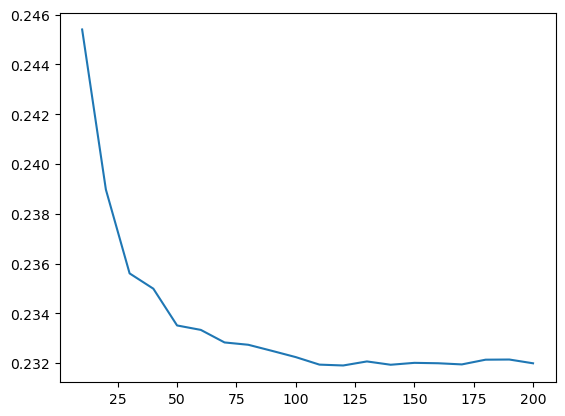

In [13]:
plt.plot(n_estimators, rmses)

#### Q3. After which value of n_estimators does RMSE stop improving?

#### 150

Let's select the best max_depth:

    Try different values of max_depth: [10, 15, 20, 25]
    For each of these values, try different values of n_estimators from 10 till 200 (with step 10)
    Fix the random seed: random_state=1

In [14]:
n_estimators = range(10, 201, 10)
max_depths = [10, 15, 20, 25]
rmses = []

for max_depth in max_depths:
    for n_estimator in n_estimators:
        rf = RandomForestRegressor(
            n_estimators=n_estimator,
            max_depth=max_depth,
            random_state=seed,
            n_jobs=-1
        )

        rf.fit(X_train, y_train)

        y_val_pred = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_val_pred, squared=False)
        rmses.append((n_estimator, max_depth, rmse))

        # print(f"{n_estimators}\t{round(rmse, 4)}")

In [15]:
df_rmses = pd.DataFrame(rmses, columns=["Estimators", "Max Depth", "RMSE"])
df_rmses[df_rmses.loc[:, "RMSE"] == df_rmses["RMSE"].min()]

,Estimators,Max Depth,RMSE
76,170,25,0.231269


#### Q4. What's the best max_depth:

#### 25

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

    Train the model with these parametes:
        n_estimators=10,
        max_depth=20,
        random_state=1,
        n_jobs=-1 (optional)
    Get the feature importance information from this model

In [16]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=seed, n_jobs=-1)
rf.fit(X_train, y_train)

df = pd.DataFrame({
    'Features': feature_names,
    'Importance': rf.feature_importances_,
})

df[df.loc[:, "Importance"] == df.Importance.max()]

,Features,Importance
4,median_income,0.363741


#### Q5. What's the most important feature?

#### median_income

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

    Install XGBoost
    Create DMatrix for train and validation
    Create a watchlist
    Train a model with these parameters for 100 rounds:

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,   
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

Now change eta first to 0.1 and then to 0.01

In [17]:
regex = re.compile(r"<", re.IGNORECASE)
# feature_names should not contain [, ] or <
feature_names = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in feature_names]

In [18]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names)

etas = [0.1, 0.3, 0.01]
rmses = []

for eta in etas:
    xgb_params = {
        'eta': eta,
        'max_depth': 6,
        'min_child_weight': 1,
        'objective': 'reg:squarederror',
        'nthread': 8,
        'seed': seed,
        'verbosity': 1
    }
    model = xgb.train(xgb_params, dtrain=dtrain, num_boost_round=100)
    y_pred = model.predict(dval)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    rmses.append(rmse)

In [19]:
df = pd.DataFrame({
    "ETA": etas,
    "RMSE": rmses
})
df
# df[df.loc[:, "RMSE"] == df.RMSE.min()]

,ETA,RMSE
0,0.10,0.232453
1,0.30,0.227837
2,0.01,4.264994


#### Q6. Which eta leads to the best RMSE score on the validation dataset?

#### 0.3